# Rainfall Prediction Project


## CSV getter

In [2]:
import csv

# Open the input text file and read its content
with open('usa.txt', 'r') as infile:
    data = infile.readlines()

# Process the data: Split each line by commas and store in a list
processed_data = [line.strip().split(',') for line in data]

# Write the processed data to a CSV file
with open('output.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(processed_data)

print("Conversion complete. 'output.csv' is created.")

Conversion complete. 'output.csv' is created.


## Data loading


In [3]:
import pandas as pd
df = pd.read_csv('output.csv')

Dividing year by month into 4 categories:

1. Winter
2. Summer
3. Monsoon
4. Spring


This method requires some more refinement to account for correct months being assigned the correct season.

In [4]:
df['Date'] = df['Date'].apply(lambda x : str(x))
df['Date'] = df['Date'].apply(lambda x : x[5:7])
df['Date'] = df['Date'].apply(lambda x : int(x))
df['Date'] = 1 + (df['Date'] // 4)
df

,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,1,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,1,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,1,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,1,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,1,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0
...,...,...,...,...,...,...,...,...,...
73095,4,Washington D.C.,40.614393,65.099438,28.778327,0.000000,54.168514,977.083747,0
73096,4,Washington D.C.,52.641643,30.610525,12.282890,0.871000,22.068055,980.591675,0
73097,4,Washington D.C.,56.492591,96.740232,2.894762,1.191956,52.336048,1016.469174,1
73098,4,Washington D.C.,65.748956,63.900004,24.632400,0.483421,76.785280,1032.396146,1


Splitting US cities into Zones:

2: Cold (high chance of rain)


1: Moderate (some chance of rain)

0: Hot (low chance of rain)


In [5]:
df['Location'].value_counts()
location_map = {
    'Chicago': 2, 'Denver': 2, 'Indianapolis': 2,
    'Philadelphia': 2, 'Washington D.C.': 2, 'New York': 2, 'Seattle': 2,
    'Austin': 0, 'Dallas': 0, 'Fort Worth': 0,
    'Houston': 0, 'Jacksonville': 0, 'Phoenix': 0, 'San Antonio': 0,
    'Charlotte': 1, 'Columbus': 1, 'Los Angeles': 1,
    'San Diego': 1, 'San Francisco': 1, 'San Jose': 1
}
df['Location'] = df['Location'].map(location_map)

Calculating a 'rain score' for each city and time of year

In [6]:
df['Rain Score'] = (df['Precipitation'] * df['Humidity']) // 2
df = df.drop(columns=['Date'])
df = df.drop(columns=['Location'])
df
df['Rain Score']

,Rain Score
0,0.0
1,7.0
2,29.0
3,2.0
4,23.0
...,...
73095,0.0
73096,13.0
73097,57.0
73098,15.0


In [7]:
rain_tmrw = df['Rain Tomorrow']
rest = df.drop(columns=['Rain Tomorrow'])
rest

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Score
0,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0.0
1,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,7.0
2,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,29.0
3,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,2.0
4,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,23.0
...,...,...,...,...,...,...,...
73095,40.614393,65.099438,28.778327,0.000000,54.168514,977.083747,0.0
73096,52.641643,30.610525,12.282890,0.871000,22.068055,980.591675,13.0
73097,56.492591,96.740232,2.894762,1.191956,52.336048,1016.469174,57.0
73098,65.748956,63.900004,24.632400,0.483421,76.785280,1032.396146,15.0


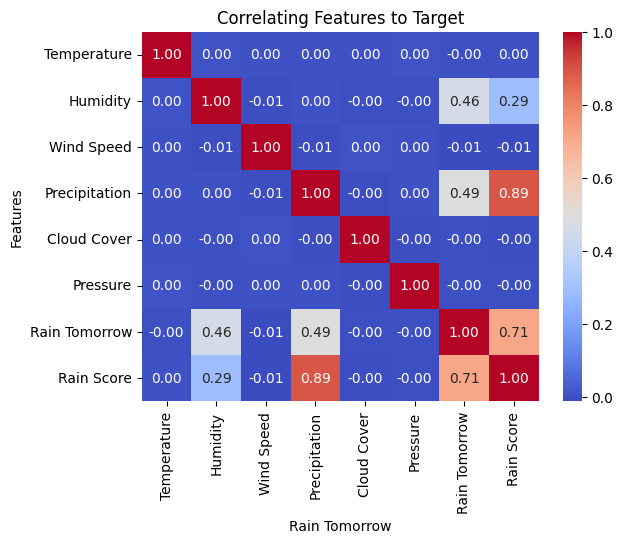

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlating Features to Target')
plt.xlabel("Rain Tomorrow")
plt.ylabel("Features")
plt.show()

# Logistic Regression

In [9]:
from sklearn.model_selection import train_test_split
rest_train, rest_test, rain_tmrw_train, rain_tmrw_test = train_test_split(rest, rain_tmrw, test_size=0.2, random_state=100)

In [10]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, f1_score, log_loss, recall_score, confusion_matrix, precision_score, classification_report
model = LogisticRegression(class_weight={0:1, 1:2}, solver="liblinear")
model.fit(rest_train, rain_tmrw_train)
pred = model.predict(rest_test)

F1-Score

In [11]:
f1_score(pred, rain_tmrw_test)

0.9144856968959221

Accuracy Score

In [12]:
accuracy_score(pred, rain_tmrw_test)

0.9615595075239398

Log Loss

In [13]:
log_loss(rain_tmrw_test, model.predict_proba(rest_test)[:, 1])

0.09671751140319378

Confusion Matrix

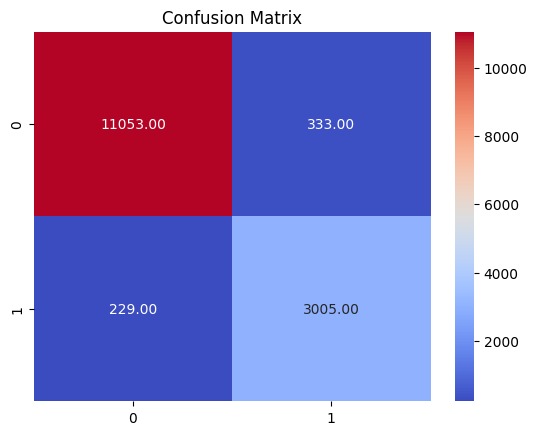

In [14]:
con = confusion_matrix(rain_tmrw_test, pred)

sns.heatmap(con, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix')

plt.show()

Precision Score from Correlation Matrix

$$ Precision = \frac{True \space Positive}{True \space Positive + False \space Positive} ≈ 93\% $$

In [15]:
con[1][1] / (con[1][1] + con[1][0]) * 100

92.91898577612864

Classification Report

In [16]:
print(classification_report(pred, rain_tmrw_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11282
           1       0.93      0.90      0.91      3338

    accuracy                           0.96     14620
   macro avg       0.95      0.94      0.94     14620
weighted avg       0.96      0.96      0.96     14620



Feature Importance

In [17]:
import numpy as np
coefficients = model.coef_[0]
feature_importance = np.abs(coefficients)
for feature, importance in zip(rest.columns, feature_importance):
    print(f"{feature}: {importance}")

Temperature: 0.0005514024360997922
Humidity: 0.0279220806093962
Wind Speed: 0.0023675634623378542
Precipitation: 31.35167151382728
Cloud Cover: 3.148503461527753e-05
Pressure: 0.0007262600994109811
Rain Score: 1.2574556096862126


# Saving Model

In [18]:
import joblib
filename = 'rain_model.joblib'
joblib.dump(model, filename)

['rain_model.joblib']